## QuasarNET Performance vs dll
#### Plot to show performance of QuasarNET as a function of the QN wavelength grid separation
xxx

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
  
import astropy
import copy
import glob
import numpy as np
from matplotlib import pyplot as plt

from quasarnet.io import read_truth
from qn_analysis import plot, strategy, utils, variables

In [2]:
figsize = (12,6.5)
fontsize = 18

plt.rc('font', size=fontsize)

### Load the results from the different QN models

In [3]:
## QN parameters
n_detect = 1
c_th = 0.8
include_c_qn = True
common_specids = True

In [4]:
f_truth = variables.OUTDIR+'/data/truth/truth_dr12q.fits'
truth = read_truth([f_truth])

In [5]:
data = {}

for dll in variables.DLL_VALUES:
    
    ## Load the QN using nchunks value.
    f_qn = glob.glob(variables.OUTDIR+'/outputs/qn_outputs/additional_setups/dll_values/dll_{}/qnAll*.fits'.format(dll))[0]
    data['QN_{}'.format(dll)] = utils.load_qn_data(f_qn,n_detect=n_detect,c_th=c_th,include_c=include_c_qn)

### Find the set of common spectra, and reduce all data to that set
This finds which spectra* are common to all datasets, and removes any that are not common. It then matches the data from each classifier to each spectrum, and produces a single data table.

\* using spec_id = plate$\times$1000000000 + mjd$\times$10000 + fiber for BOSS, or spec_id = targetid for DESI (to be updated)

In [6]:
data_table = utils.reduce_data_to_table(data,truth,include_c_qn=include_c_qn,common_specids=False)
data_table[:5]

SPEC_ID,OBJ_ID,ZCONF_PERSON,Z_VI,CLASS_VI,ISQSO_VI,Z_QN_0.002,CLASS_QN_0.002,ISQSO_QN_0.002,C_QN_0.002 [6],Z_LINES_QN_0.002 [6],Z_QN_0.001,CLASS_QN_0.001,ISQSO_QN_0.001,C_QN_0.001 [6],Z_LINES_QN_0.001 [6],Z_QN_0.0005,CLASS_QN_0.0005,ISQSO_QN_0.0005,C_QN_0.0005 [6],Z_LINES_QN_0.0005 [6]
int64,int64,int64,float64,str8,bool,float64,str8,bool,float64,float64,float64,str8,bool,float64,float64,float64,str8,bool,float64,float64
7166566020362,20589337,2,1.616,QSO,True,1.603,QSO,True,0.000 .. 0.000,2.278 .. 0.337,1.635,NONQSO,False,0.005 .. 0.000,2.277 .. -0.362,1.647,NONQSO,False,0.000 .. 0.000,4.395 .. 0.079
7166566020367,20603085,2,2.070,QSO,True,2.089,NONQSO,False,0.579 .. 0.000,2.089 .. -0.282,2.069,QSO,True,0.990 .. 0.000,2.069 .. -0.329,2.087,QSO,True,0.818 .. 0.000,2.086 .. 0.319
7169566280047,20935261,2,0.000,STAR,False,1.459,NONQSO,False,0.000 .. 0.000,5.514 .. 0.464,3.973,NONQSO,False,0.000 .. 0.000,2.352 .. -0.392,2.680,NONQSO,False,0.000 .. 0.000,3.570 .. -0.388
7169566280046,20935742,2,0.000,STAR,False,0.568,NONQSO,False,0.000 .. 0.000,3.174 .. 0.499,0.566,NONQSO,False,0.000 .. 0.000,5.006 .. 0.483,0.468,NONQSO,False,0.000 .. 0.000,4.663 .. 0.492
7169566280052,20936956,2,0.000,STAR,False,3.588,NONQSO,False,0.000 .. 0.000,3.588 .. 0.344,3.937,NONQSO,False,0.000 .. 0.000,3.851 .. 0.083,1.288,NONQSO,False,0.000 .. 0.000,2.303 .. -0.390


In [7]:
# Include only objects in the data table that have the highest confidence level, and VI redshift not equal to -1.
w = (data_table['ZCONF_PERSON']==2) & (data_table['Z_VI']>-1)
data_table = data_table[w]
len(data_table)

568358

### Compare the performance of the different model/data combos.
xxx

In [8]:
ls = {'QN_0.001': '-',
      'QN_0.002': '--',
      'QN_0.0005': ':',
     }

In [9]:
## Define general parameter values.
dv_max = 6000.

# confidence thresholds.
c_th_min = 0.0
c_th_max = 1.0
n_int = 101
c_th_values = np.linspace(c_th_min,c_th_max,n_int)

In [11]:
## Define strategies.
strategies = {}

for s in data.keys():
    
    nchunks = float(s.split('_')[-1])
    name = r'$\Delta\log(\lambda)={}$'.format(nchunks)
    if type(data_table['ISQSO_{}'.format(s)])==astropy.table.column.MaskedColumn:
        filt = (~data_table['ISQSO_{}'.format(s)].data.mask)
    else:
        filt = np.ones(len(data_table)).astype(bool)
    temp_data_table = data_table[filt]
    
    # QN definitions.
    n_detect = 1
    strat = strategy.Strategy('qn',cf_kwargs={'qn_name':s})
    preds = [strat.predict(temp_data_table,c_kwargs={'c_th':c_th_value,'n_detect':n_detect}) for c_th_value in c_th_values]
    strategies[s] = {'predictions': preds,
                     'n': name, 
                     'ls': ls[s]}

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:35: RuntimeWarning: invalid value encountered in long_scalars
  pur = pur_num/pur_denom
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:293: RuntimeWarning: invalid value encountered in greater
  strategies[s]['pur'] = pur
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:328: RuntimeWarning: invalid value encountered in greater
  print('Strategy {}:'.format(s))
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Strategy QN_0.002:
Crossover occurs at:
cth: [0.07 0.08 0.09 0.1 ]
pur: [0.9929 0.9932 0.9934 0.9936]
com: [0.9936 0.9935 0.9933 0.9932]
QN_0.002 has median velocity error -6.863 and standard deviation 767.459

Strategy QN_0.001:
Crossover occurs at:
cth: [0.06 0.07 0.08 0.09]
pur: [0.9935 0.9938 0.9941 0.9943]
com: [0.994  0.9939 0.9938 0.9937]
QN_0.001 has median velocity error 3.564 and standard deviation 796.560

Strategy QN_0.0005:
Crossover occurs at:
cth: [0.36 0.37 0.38 0.39]
pur: [0.9912 0.9913 0.9914 0.9916]
com: [0.9914 0.9914 0.9913 0.9912]
QN_0.0005 has median velocity error 49.659 and standard deviation 873.518



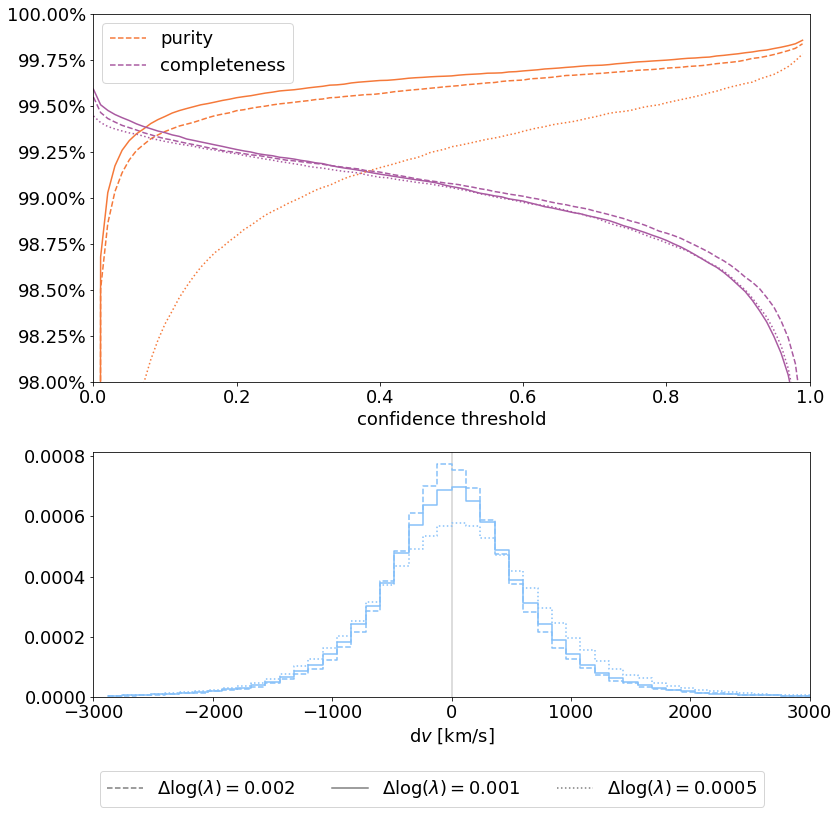

In [15]:
filename = '../plots/qn_performance_vs_dll.pdf'

plot.plot_qn_model_compare(data_table,strategies,filename=filename,
                           dv_max=dv_max,nydec=2,figsize=(12,12),
                           ymin=0.98,ymax=1.,verbose=True,npanel=2,
                           norm_dvhist=True,c_th=c_th_values)
plt.show()